## Importação de Bibliotecas Utilizadas

In [ ]:
#Importação de bibliotecas necessárias 
import pandas as pd
import numpy as np
import re 
import os
import nltk
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

## Variáveis / Constantes

In [ ]:
# Pasta de entrada para arquivos tratados
input_path = "../data/datasets_pos_tratamento"

#caminho/nomeDoArquivo
fileMeta = os.path.join(input_path, "meta_tratados.parquet")

## Leitura e verificação dos Datasets (Análise Exploratória)

In [3]:
#Leitura de dataset 2 (Informações)

dfMeta = pd.read_parquet(fileMeta, engine="pyarrow")
#headers das colunas
print(dfMeta.columns) 

#tamanho (linhas, colunas)
dfMeta.shape
numberColumnsMeta = dfMeta.shape[1]

Index(['IDENTIFICADOR', 'TITULO', 'MEDIA_VOTOS', 'QTD_AVALIACOES',
       'CARACTERISTICAS', 'DESCRICAO', 'PRECO', 'LOJA', 'DETALHES',
       'CATEGORIAS'],
      dtype='object')


In [4]:
#Exibe as linhas iniciais
dfMeta.head()

,IDENTIFICADOR,TITULO,MEDIA_VOTOS,QTD_AVALIACOES,CARACTERISTICAS,DESCRICAO,PRECO,LOJA,DETALHES,CATEGORIAS
52011,B08V9799ZG,"Electric Can Opener, Restaurant Can Opener, Fu...",2.7,23,,,15.040000,W-Dragon,"Date First Available, Color, Material, Brand, ...","Home & Kitchen, Kitchen & Dining, Kitchen Uten..."
67694,B09JGJ7D1S,"PAPAISON Roller Skates for Women and Men, Delu...",4.6,720,【RETRO STYLE 】 Classic high top double-row rol...,,79.989998,PAPAISON,"Size, Color, Brand, Wheel Material, Wheel Type...","Sports & Outdoors, Sports, Skates, Skateboards..."
3050,B06XB6LF6Y,Dewhel Sport Front Bumper Tow Hook License Pla...,3.4,166,"High quality aluminum Tow hook License Plate,B...",Tow Hook License Plate Fitments:2000-2009 Hond...,20.990000,DEWHEL,"Manufacturer, Brand, Item Weight, Package Dime...","Automotive, Exterior Accessories, License Plat..."
66635,B07RSM5PRD,JR Studio 3x5 inch Yellow Combat Vet Tab Shape...,4.2,13,Size: Check Item title - Professionally made i...,,4.990000,JR Studio,"Brand, Color, Room Type, Recommended Uses For ...","Sports & Outdoors, Fan Shop, Auto Accessories,..."
64560,B08KXF2S4V,"Horsemen's Pride Horse Feed Tub, Small, 18 Qua...",4.4,36,This small/mini feed tub measures 14 inches ac...,The Small Feed Tub measures 14 inches across (...,32.590000,Jolly Pets,"Product Dimensions, Item model number, Date Fi...","Pet Supplies, Horses, Stable Supplies, Feeding..."


In [5]:
#Exibe as linhas iniciais
dfMeta.tail()

,IDENTIFICADOR,TITULO,MEDIA_VOTOS,QTD_AVALIACOES,CARACTERISTICAS,DESCRICAO,PRECO,LOJA,DETALHES,CATEGORIAS
37194,B082B8WPW5,"THRRLY Airpods Case, Girls Cute Clear Airpods ...",4.3,85,【Compatibility】This case designed for Airpods ...,"Compatibity:, Compatible with Apple Airpods 1s...",11.980000,THRRLY,"Package Dimensions, Item Weight, Manufacturer,...","Electronics, Headphones, Earbuds & Accessories..."
6265,B09G6QB78V,MAYASAF EGR Valve EGV598 1998 99 2000 01 02 03...,4.1,13,【Part Fitment】For 1998-2004 Pathfinder;Frontie...,,44.990002,MAYASAF,"Manufacturer, Part Number, Item Weight, Packag...","Automotive, Replacement Parts, Exhaust & Emiss..."
54886,B08LXSPQZC,Avana Chaise Lounge Chair for Stretching and R...,4.2,52,COMFY & UNIQUE -- Comfortable and unique style...,,439.000000,Avana,"Color, Brand, Product Dimensions, Style, Speci...","Home & Kitchen, Furniture, Living Room Furnitu..."
860,B08PMQJRYQ,NIXON District Beanie,4.2,11,"100% Acrylic, Made in USA or Imported, Machine...",The primary materials that compose this produc...,16.000000,NIXON,"Department, Date First Available, Manufacturer",AMAZON FASHION
15795,1101908211,Poems from Greek Antiquity (Everyman's Library...,4.7,40,A beautiful Pocket Poet selection of short poe...,"About the Author, PAUL QUARRIE, author of, Win...",15.950000,Paul Quarrie (Editor),"Publisher, Language, Hardcover, ISBN 10, ISBN ...","Books, Literature & Fiction, Poetry"


## Pré-processamento de dados

### Seleção de colunas utilizadas

In [8]:
dfMeta = dfMeta[['TITULO', 'MEDIA_VOTOS', 'QTD_AVALIACOES', 'CARACTERISTICAS', 'DESCRICAO', 'LOJA', 'DETALHES', 'CATEGORIAS']]

In [9]:
# Ajustando o df para conter apenas produtos com mais de X avaliações
#qtdMinReviewsPerProduct = 100
#dfMeta = dfMeta[dfMeta['QTD_AVALIACOES'] > qtdMinReviewsPerProduct]

## Função de busca de títulos

In [ ]:
def searchProductName(product_name, quantity=10, dataframe=dfMeta):
    """
    Função para buscar produtos pelo nome e mostrar os primeiros resultados.
    """
    
    mask = pd.Series(dataframe.index).str.lower().str.contains(product_name.lower())
    results = dataframe.index[mask]
    if len(results) > 0:
	    for title in results[:quantity]:
		    print(title)
    else:
       print("Nenhum produto encontrado.")

## Recomendação CosineSimilarity com TFidf (KNN / Linear Kernel)

### Frequência de aparição de palavras

#### Visualizando frequência de tokens com e sem a remoção de Stop Words

In [9]:
dfMeta.head()

,TITULO,MEDIA_VOTOS,QTD_AVALIACOES,CARACTERISTICAS,DESCRICAO,LOJA,DETALHES,CATEGORIAS
52011,"Electric Can Opener, Restaurant Can Opener, Fu...",2.7,23,,,W-Dragon,"Date First Available, Color, Material, Brand, ...","Home & Kitchen, Kitchen & Dining, Kitchen Uten..."
67694,"PAPAISON Roller Skates for Women and Men, Delu...",4.6,720,【RETRO STYLE 】 Classic high top double-row rol...,,PAPAISON,"Size, Color, Brand, Wheel Material, Wheel Type...","Sports & Outdoors, Sports, Skates, Skateboards..."
3050,Dewhel Sport Front Bumper Tow Hook License Pla...,3.4,166,"High quality aluminum Tow hook License Plate,B...",Tow Hook License Plate Fitments:2000-2009 Hond...,DEWHEL,"Manufacturer, Brand, Item Weight, Package Dime...","Automotive, Exterior Accessories, License Plat..."
66635,JR Studio 3x5 inch Yellow Combat Vet Tab Shape...,4.2,13,Size: Check Item title - Professionally made i...,,JR Studio,"Brand, Color, Room Type, Recommended Uses For ...","Sports & Outdoors, Fan Shop, Auto Accessories,..."
64560,"Horsemen's Pride Horse Feed Tub, Small, 18 Qua...",4.4,36,This small/mini feed tub measures 14 inches ac...,The Small Feed Tub measures 14 inches across (...,Jolly Pets,"Product Dimensions, Item model number, Date Fi...","Pet Supplies, Horses, Stable Supplies, Feeding..."


In [10]:
def plotBarCountCaracteristicas(df, title):
    plt.figure(figsize=(12, 6))
    bars = plt.bar(df['CARACTERISTICAS'], df['count'], color='black')
    plt.title(title, fontsize=14)
    plt.xlabel('Palavras')
    plt.ylabel('Contagem')
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

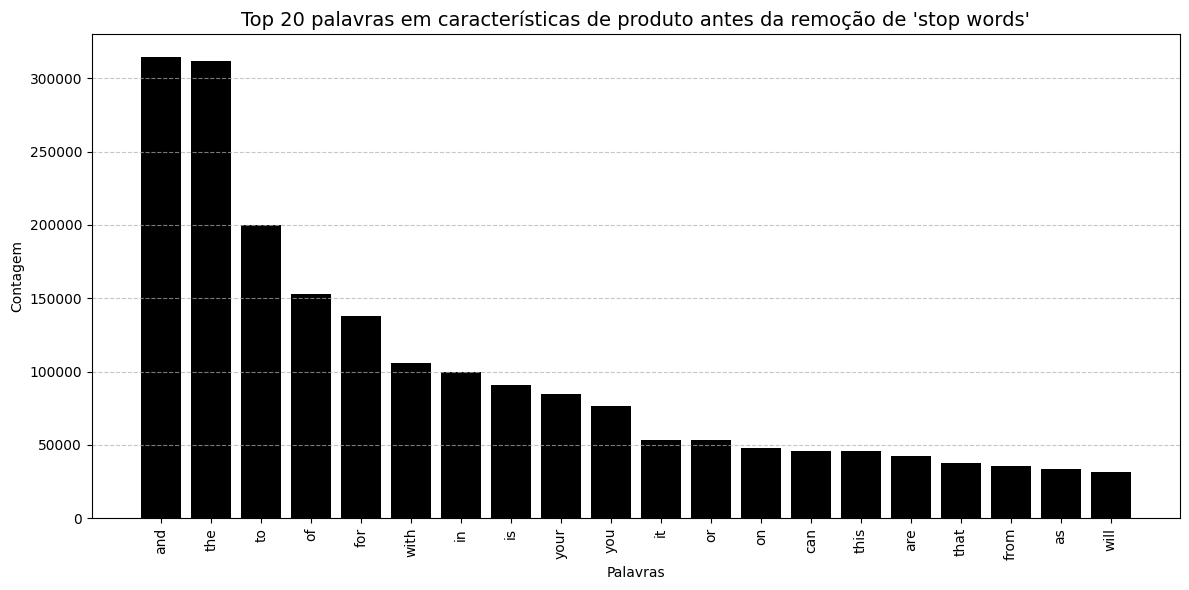

In [ ]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(dfMeta['CARACTERISTICAS'], 20)
df1 = pd.DataFrame(common_words, columns = ['CARACTERISTICAS', 'count'])

plotBarCountCaracteristicas(df1, "Top 20 palavras em características de produto antes da remoção de 'stop words'")

*OBS: Adicionar um stop words personalizado com as palavras não desejadas*

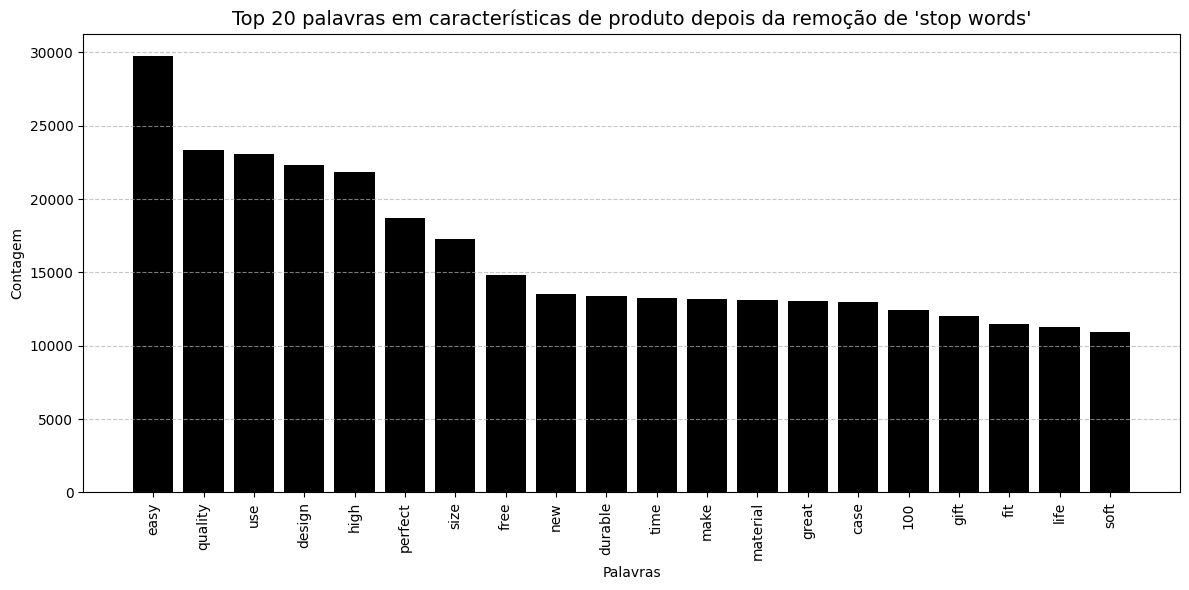

In [ ]:
def get_top_n_words(corpus, n=None):

    # Define as stopwords padrão do inglês
    stop_words = set(CountVectorizer(stop_words='english').get_stop_words())
    #Adicionando palavras que não trazem valor
    stop_words.add("amazon")
    stop_words.add("com")

    # Converte o conjunto de stopwords para uma lista
    stop_words = list(stop_words)

     # Inicializa o CountVectorizer com as stopwords personalizadas
    vec = CountVectorizer(stop_words=stop_words).fit(corpus)

    # Calcula a frequência das palavras
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    
    # Ordena as palavras pela frequência
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

common_words = get_top_n_words(dfMeta['CARACTERISTICAS'], 20)
df1 = pd.DataFrame(common_words, columns = ['CARACTERISTICAS', 'count'])
plotBarCountCaracteristicas(df1, "Top 20 palavras em características de produto depois da remoção de 'stop words'")


##### Bigramas (2 termos) e frequência de tokens com e sem remoção de stop words

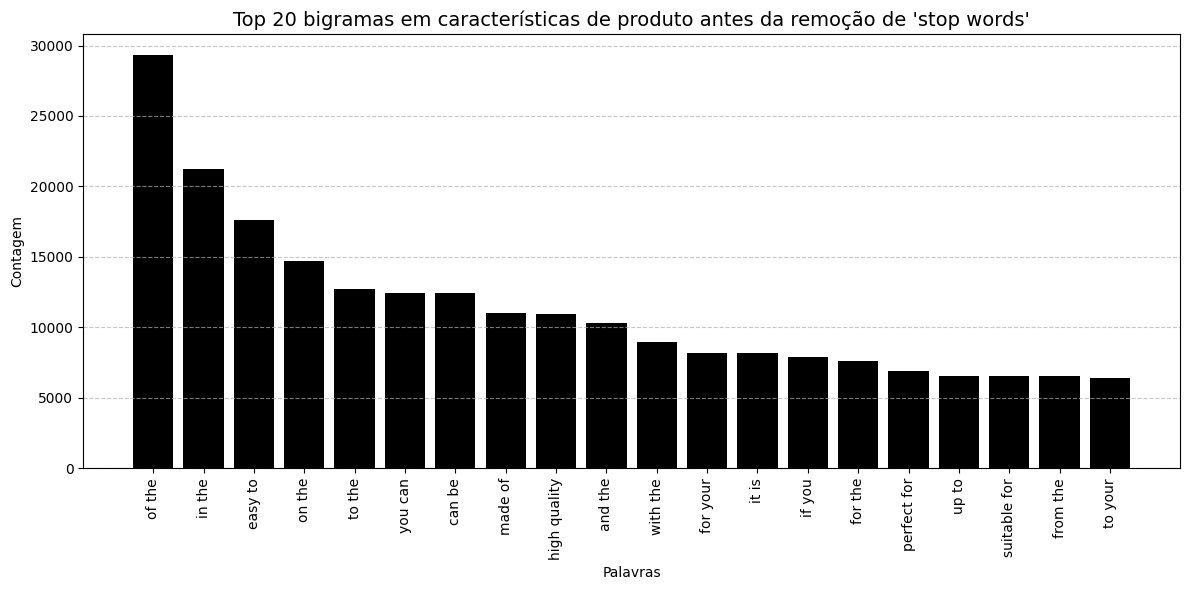

In [ ]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(dfMeta['CARACTERISTICAS'], 20)
df1 = pd.DataFrame(common_words, columns = ['CARACTERISTICAS', 'count'])
plotBarCountCaracteristicas(df1, "Top 20 bigramas em características de produto antes da remoção de 'stop words'")

In [ ]:
def get_top_n_bigrams(corpus, n=None):

    # Define as stopwords padrão do inglês
    stop_words = set(CountVectorizer(stop_words='english').get_stop_words())
    #Adicionando palavras que não trazem valor
    stop_words.add("amazon")
    stop_words.add("com")

    # Converte o conjunto de stopwords para uma lista
    stop_words = list(stop_words)

     # Inicializa o CountVectorizer com as stopwords personalizadas
    vec = CountVectorizer(ngram_range=(2, 2), stop_words=stop_words).fit(corpus)

    # Calcula a frequência das palavras
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    
    # Ordena as palavras pela frequência
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

common_words = get_top_n_bigrams(dfMeta['CARACTERISTICAS'], 20)
df1 = pd.DataFrame(common_words, columns = ['CARACTERISTICAS', 'count'])
plotBarCountCaracteristicas(df1, "Top 20 bigramas em características de produto depois da remoção de 'stop words'")

##### Trigramas (3 termos) e frequência de tokens com e sem remoção de stop words

In [ ]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigram(dfMeta['CARACTERISTICAS'], 20)
df1 = pd.DataFrame(common_words, columns = ['CARACTERISTICAS', 'count'])
plotBarCountCaracteristicas(df1, "Top 20 trigramas em características de produto antes da remoção de 'stop words'")

In [ ]:
def get_top_n_trigrams(corpus, n=None):

    # Define as stopwords padrão do inglês
    stop_words = set(CountVectorizer(stop_words='english').get_stop_words())
    #Adicionando palavras que não trazem valor
    stop_words.add("amazon")
    stop_words.add("com")

    # Converte o conjunto de stopwords para uma lista
    stop_words = list(stop_words)

     # Inicializa o CountVectorizer com as stopwords personalizadas
    vec = CountVectorizer(ngram_range=(3, 3), stop_words=stop_words).fit(corpus)

    # Calcula a frequência das palavras
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    
    # Ordena as palavras pela frequência
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

common_words = get_top_n_trigrams(dfMeta['CARACTERISTICAS'], 20)
df1 = pd.DataFrame(common_words, columns = ['CARACTERISTICAS', 'count'])
plotBarCountCaracteristicas(df1, "Top 20 trigramas em características de produto depois da remoção de 'stop words'")

### Limpeza de dados de texto

In [9]:
dfMeta.head(20)

,TITULO,MEDIA_VOTOS,QTD_AVALIACOES,CARACTERISTICAS,DESCRICAO,LOJA,DETALHES,CATEGORIAS
52011,"Electric Can Opener, Restaurant Can Opener, Fu...",2.7,23,,,W-Dragon,"Date First Available, Color, Material, Brand, ...","Home & Kitchen, Kitchen & Dining, Kitchen Uten..."
67694,"PAPAISON Roller Skates for Women and Men, Delu...",4.6,720,【RETRO STYLE 】 Classic high top double-row rol...,,PAPAISON,"Size, Color, Brand, Wheel Material, Wheel Type...","Sports & Outdoors, Sports, Skates, Skateboards..."
3050,Dewhel Sport Front Bumper Tow Hook License Pla...,3.4,166,"High quality aluminum Tow hook License Plate,B...",Tow Hook License Plate Fitments:2000-2009 Hond...,DEWHEL,"Manufacturer, Brand, Item Weight, Package Dime...","Automotive, Exterior Accessories, License Plat..."
66635,JR Studio 3x5 inch Yellow Combat Vet Tab Shape...,4.2,13,Size: Check Item title - Professionally made i...,,JR Studio,"Brand, Color, Room Type, Recommended Uses For ...","Sports & Outdoors, Fan Shop, Auto Accessories,..."
64560,"Horsemen's Pride Horse Feed Tub, Small, 18 Qua...",4.4,36,This small/mini feed tub measures 14 inches ac...,The Small Feed Tub measures 14 inches across (...,Jolly Pets,"Product Dimensions, Item model number, Date Fi...","Pet Supplies, Horses, Stable Supplies, Feeding..."
59776,"pingpi Gaming Mouse Pad Custom, The Romantic T...",4.8,3173,"MousePad Size: 9.5""x7.9""( 240mm x 200mm x 3mm)...",Welcome to Pingpi store to order Mouse Pad. We...,pingpi,"Manufacturer, Brand, Item Weight, Product Dime...","Office Products, Office & School Supplies, Des..."
9801,DC Nation Presents DC Future State #1,4.2,230,,,Various (Author),"Publisher, Language, Item Weight",Books
70758,Bionic Body Workout Bar for Power Lifting Stre...,4.1,22,SOLID CONSTRUCTION – 36” bar high-quality stee...,Get a full body workout with the Bionic Body E...,BIONIC BODY,"Item Package Dimensions L x W x H, Package Wei...","Sports & Outdoors, Exercise & Fitness, Strengt..."
26357,Cool & Unusual,5.0,11,,,Martin Simpson Format: Audio CD,"Is Discontinued By Manufacturer, Language, Pro...","CDs & Vinyl, Folk, British & Celtic Folk, Brit..."
44481,ALEXANDRA'S SECRET HOME COLLECTION Microfiber ...,4.6,2086,"Microfiber, Standard-(20"" x 26""), Queen-(20"" x...",,ALEXANDRA'S SECRET HOME COLLECTION,"Brand, Material, Size, Color, Closure Type, Ca...","Home & Kitchen, Bedding, Decorative Pillows, I..."


In [15]:
# Baixa os dados de stopwords, caso ainda não estejam disponíveis
nltk.download('stopwords')

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
ADDITIONALWORDS = list(['amazon', 'amazoncom'])

def clean_text(text):
    """
        text: uma string
        return: versão limpa
    """

    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS and word not in ADDITIONALWORDS)
    return text

dfMeta['CARACTERISTICAS'] = dfMeta['CARACTERISTICAS'].apply(clean_text)
dfMeta['DESCRICAO'] = dfMeta['DESCRICAO'].apply(clean_text)
dfMeta['DETALHES'] = dfMeta['DETALHES'].apply(clean_text)

#Drop de coluna não necessária
dfMeta.drop('CATEGORIAS', axis=1, inplace=True)

# Seleção de colunas relevantes e concatená-las em uma só utilizada pelo algoritmo
dfMeta['CONCATENATED'] = dfMeta.apply(
    lambda x: f"{x['DESCRICAO']} {x['CARACTERISTICAS']} {x['DETALHES']} Store {x['LOJA']}", axis=1)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\everson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
def print_info(index):
    if index not in dfMeta.index:
        print("Elemento não encontrado")
        return
    example = dfMeta[dfMeta.index == index][['CARACTERISTICAS', 'DESCRICAO', 'DETALHES']].values[0]
    if len(example) > 0:
        print('Titulo: ', index)
        print('Caracteristicas: ', example[0])
        print('Descricao: ', example[1])
        print('Detalhes: ', example[2])
print_info(2)

Titulo:  2
Caracteristicas:  false toenails durable perfect length option wear long clip short easy trim file length shape like abs kind green enviromental material makes nails durable breathable light even pressure nails fit well natural toenails non toxic smell harm health wonderful gift girlfriend family friends easiest efficient way toenail tips manicures nail art designs fashion creative useful accessory brighten look also gift
Descricao:  description false toenails durable perfect length option wear long clip short easy trim file length shape like plus abs kind green enviromental material makes nails durable breathable light even pressure toenails fit well natural toenails non toxic smell harm health feature color shown material abs size 143 x 72 x 1cm package including 100 x pieces fake toenails
Detalhes:  color size material brand style product dimensions upc manufacturer


In [17]:
dfMeta.set_index('TITULO', inplace = True)

### Criação do Tfid Vectorizer

In [18]:
# Criando a matriz TF-IDF
#ngram range indica que irá capturar unigramas, bigramas e trigramas
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0.0, stop_words='english')

### Aplicação do KNN

#### Tratamento

In [19]:
tfidf_matrix = tf.fit_transform(dfMeta['CONCATENATED'])

#### Criação da Máquina Preditiva

In [20]:
# Criando e e treinando o modelo

model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(tfidf_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
def recommendationWithContentKNN(product, num_of_elements=4):
    
    try:
        
        if product is None or product.strip() == "":
           raise ValueError("Forneça um nome de produto válido.")
    
        if(product not in dfMeta.index):
            print(f"Produto '{product}' não encontrado.")
            return
        
        # Recupera o índice da linha correspondente ao título
        product_idx = dfMeta.index.get_loc(product)

        # Encontra vizinhos mais próximos
        distances, sugestions = model.kneighbors(tfidf_matrix[product_idx], n_neighbors=num_of_elements + 1)

        print(f"Produto escolhido: '{product}'\n")
        print(f"Top {num_of_elements} recomendações:")
        for i in range(len(sugestions[0])):
            suggested_idx = sugestions[0][i]
            suggested_title = dfMeta.index[suggested_idx]
            
            if suggested_title == product:
                continue
                
            print(suggested_title)
            # print(f"Similaridade: {1 - distances[0][i]:.4f}\n")
            
    except ValueError as e:
        print(e)

#### Funcionamento

In [34]:
searchProductName(input('Pesquise aqui o produto:'), 10) 

Pesquise aqui o produto: rtx 206


PNY GeForce RTX 2060 Super 8GB XLR8 Gaming Overclocked Edition Graphics Card (VCG20608SDFPPB-O)
2021 Acer Predator Helios 300 17.3" FHD IPS 144Hz Premium Gaming Laptop, 10th Gen Intel Core i7-10750H, 16GB RAM, 512GB PCIe SSD, NVIDIA GeForce RTX 2060 6GB GDDR6, RGB Backlit Keyboard, Windows 10


In [37]:
recommendationWithContentKNN(input('Entre com um produto que tenha gostado: '), 20) 

Entre com um produto que tenha gostado:  LEGO Star Wars Poe Dameron's X-Wing Fighter 75273 Building Kit, Cool Construction Toy for Kids, New 2020 (761 Pieces)


Produto escolhido: 'LEGO Star Wars Poe Dameron's X-Wing Fighter 75273 Building Kit, Cool Construction Toy for Kids, New 2020 (761 Pieces)'

Top 20 recomendações:
IQ Lego Star Wars Poe Dameron LED Head Lamp
The Northwest Company Star Wars Han Solo in Carbonite Fleece Throw Blanket 46" x 60"
STAR WARS The Vintage Collection Bo-Katan Kryze Toy, 3.75-Inch-Scale The Mandalorian Action Figure, Toys for Kids Ages 4 and Up,F4465
Star Wars R2D2 Character One Size Fits Most Novelty Leggings
Star Wars Speeder Bike With Darth Maul
Star Wars Lego 75046 Coruscant Police Gunship
Hot Wheels Star Wars Character Car #2
We Are the Resistance (Star Wars) (Little Golden Book)
Star Wars Rogue One Series Darth Vader 12 Inch Figure
Star Wars Darth Vader (11") Mini Toddler Preschool Backpack (Plush Front)
Star Wars Mug - Darth Vader Imperial Porcelain Coffee Cup - 10 oz
Funko POP Star Wars: The Mandalorian Action Figure Boba Fett
STAR WARS Chewbacca Costume PJ PALS Pajamas for Kids Size 8
Bladez Toyz Star Wars

### Aplicação do linear kernel

In [18]:
# Estouro de memória
# cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

#### Tratamento

In [38]:
# Ajustado conforme RAM disponível
dfSample = dfMeta.sample(n=20000, random_state=42)
tfidf_matrix = tf.fit_transform(dfSample['CONCATENATED'])

#### Criação da Máquina Preditiva

In [39]:
dfSample = dfMeta.sample(n=20000, random_state=42)
tfidf_matrix = tf.fit_transform(dfSample['CONCATENATED'])
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
def recommendationWithLinearKernel(product, num_of_elements=10):
    
    try:
        
        if product is None or product.strip() == "":
           raise ValueError("Forneça um nome de produto válido.")
        
        if(product not in dfSample.index):
            print(f"Produto '{product}' não encontrado.")
            return
        
        recommended_products = []

        indices = pd.Series(dfSample.index)
        
        #obtendo o índice pelo nome
        idx = indices[indices == product].index[0]

        # criando uma série com as pontuações de similaridade
        score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)

        # obtendo os índices dos x produtos semelhantes 
        top_indexes = list(score_series.iloc[1:num_of_elements].index)

        # preenchendo a lista com esses produtos
        for i in top_indexes:
            recommended_products.append(list(dfMeta.index)[i])

        # Os imprime
        print(f"Produto escolhido: '{product}'\n")
        print(f'Top {num_of_elements} recomendações:')
        for recommended in recommended_products:
            print(recommended)
    except Exception as e:
        print(e)

#### Funcionamento

In [53]:
searchProductName(input('Pesquise aqui o produto:'), 10, dfSample)

Pesquise aqui o produto: energy


Global Science: Energy, Resources, Environment
Optimox Iodoral 12.5 mg - Original High Potency Lugol Solution Iodine Nutritional Supplement - Energy and Thyroid Support - 180 Tablets​
Weight Loss Detox Cleanse with Garcinia Cambogia - Energy Metabolism Booster for Weight Management - Ginger Root for Digestive Health - Vegan & Vegetarian Friendly - 14 Servings - Anser by Tia Mowry
NICETOWN Kitchen Blackout Curtains and Drapes - Triple Weave Energy Saving Thermal Insulated Solid Grommet Blackout Panels for Patio (1 Pair, 52 inches by 72 Inch, Cappuccino)
Sustain Male Supplement - All Natural Stamina Support - Revitalize Strength - Improve Energy Level - Optimize Vitality - Formulated for Men and Women with Active Lifestyle (Trial Pack, 4 Capsules)
C4 Smart Energy Drink - Sugar Free Performance Fuel & Nootropic Brain Booster, Coffee Substitute or Alternative | Black Cherry 16 Oz - 12 Pack
Jet International Crystal Jet Chakra Chips Bracelet Free Booklet therapy Unique Gift Balancing Positi

In [54]:
recommendationWithLinearKernel(input('Entre com um produto que tenha gostado: '), 15)  

Entre com um produto que tenha gostado:  C4 Smart Energy Drink - Sugar Free Performance Fuel & Nootropic Brain Booster, Coffee Substitute or Alternative | Black Cherry 16 Oz - 12 Pack


Produto escolhido: 'C4 Smart Energy Drink - Sugar Free Performance Fuel & Nootropic Brain Booster, Coffee Substitute or Alternative | Black Cherry 16 Oz - 12 Pack'

Top 15 recomendações:
Mod Made Mid Century Modern Bubble Wall Mounted Coat Rack, Multi Color
Lionel Logo Christmas Ornaments
MOLIMAO Glass Vase for Centerpieces,Modern Large Vase for Flowers,Footprint Shape Striped Bottle for Home,Office Restaurant Desk Decor 8.3 Inch(Blue)
Bear Grips Extra Strength Weight Lifting Wrist Wraps | Wrist Straps for Weightlifting Men and Women | Wrist Support Brace for Wrist Pain Relief, Lift More Weight for Bench, Gym, Powerlifting 12" & 18"
1Storm Motorcycle Modular Flip up Full Face Helmet Shield Chrome Visor: Helmet Model HB89 only
The Missings
Evolur Ann Beechwood 4-in-1 Highchair | 360 Seat Rotation | Booster seat | Floor Chair | Bar Stool Chair | 5 Point Safety Harness | Blue
DecoGlow Harmony 3-Inch by 4-Inch Pillar Candle
Bigyonger Women's Round Neck Slim Sleeveless Pleated Maxi Dress Gr